In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("husl")
import os
print(os.listdir("../input/"))
import warnings
warnings.filterwarnings('ignore')
import gc
from pathlib import Path
from PIL import Image, ImageOps, ImageFilter
import cv2
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

['labels.csv', 'train', 'test', 'train.csv', 'sample_submission.csv']


## labels.csv

In [2]:
labels_df = pd.read_csv("../input/labels.csv")

In [3]:
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [4]:
labels_df.tail()

,attribute_id,attribute_name
1098,1098,tag::writing implements
1099,1099,tag::writing systems
1100,1100,tag::zeus
1101,1101,tag::zigzag pattern
1102,1102,tag::zodiac


In [7]:
label_dict = labels_df.attribute_name.to_dict()

## train.csv

In [8]:
train_df = pd.read_csv("../input/train.csv")
train_df.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


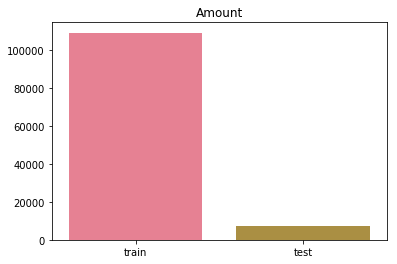

In [31]:
test_path = Path("../input/test/")
test_num = len(list(test_path.glob("*.png")))
train_num = len(train_df)
fig, ax = plt.subplots()
sns.barplot(x=["train", "test"], y=[train_num, test_num])
ax.set_title("Amount")
clear_output()

In [10]:
id_len_dict = {}
id_num_dict = {}
for i in range(train_df.shape[0]):
    ids = list(map(int, train_df.attribute_ids[i].split()))
    id_len = len(ids)
    if(id_len in id_len_dict.keys()):
        id_len_dict[id_len] += 1
    else:
        id_len_dict[id_len] = 1
    for num in ids:
        if(num in id_num_dict.keys()):
            id_num_dict[num] += 1
        else:
            id_num_dict[num] = 1

Text(0.5, 1.0, 'Numbber of tag')

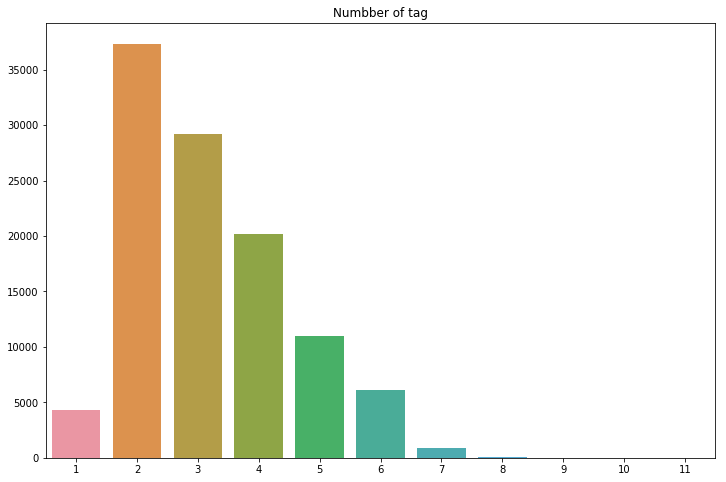

In [49]:
plt.subplots(1, 1, figsize=(12, 8))
ax1 = sns.barplot(x=list(id_len_dict.keys()), y=list(id_len_dict.values()))
ax1.set_title("Numbber of tag")

## images

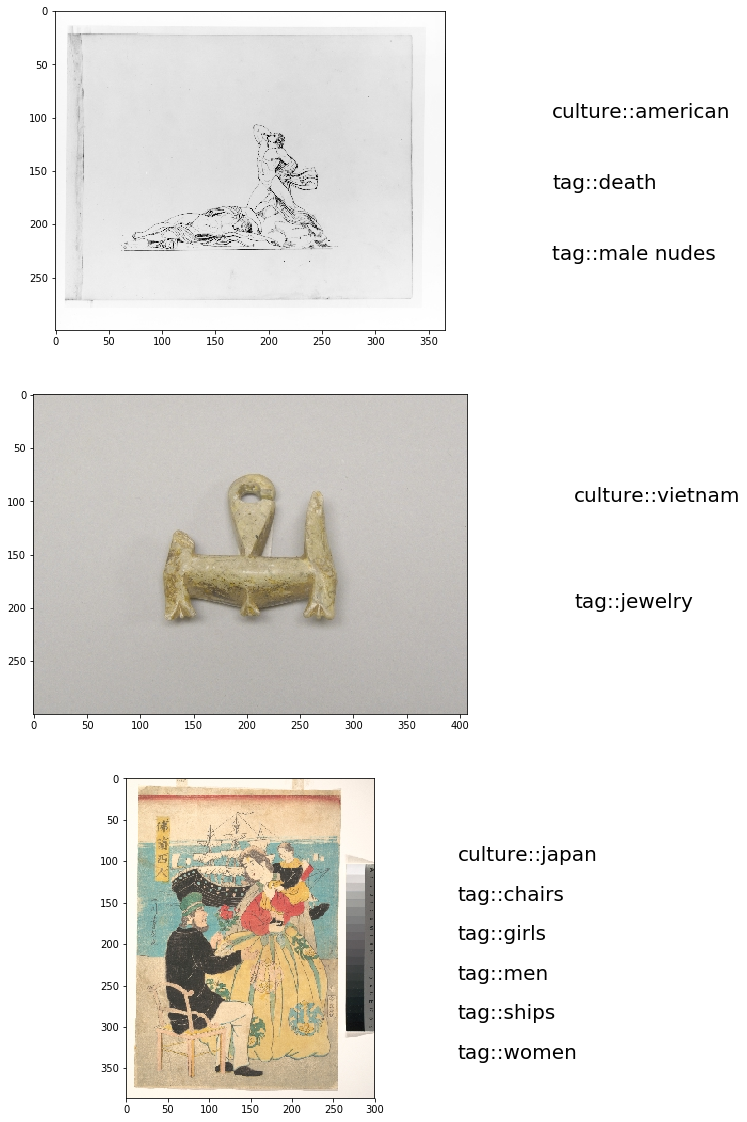

In [51]:
train_path = Path("../input/train/")
fig, ax = plt.subplots(3, figsize=(10, 20))
for i, index in enumerate(np.random.randint(0, len(train_df), 3)):
    path = (train_path / (train_df.id[index] + ".png"))
    img = np.asarray(Image.open(str(path)))
    ax[i].imshow(img)
    ids = list(map(int, train_df.attribute_ids[index].split()))
    for num, attribute_id in enumerate(ids):
        x_pos = img.shape[1] + 100
        y_pos = (img.shape[0] - 100) / len(ids) * num + 100
        ax[i].text(x_pos, y_pos, label_dict[attribute_id], fontsize=20)

In [17]:
def check_img_size(folder_path):
    area_list = []
    max_width = None
    min_width = None
    max_height = None
    min_height = None
    img_paths = list(folder_path.glob("*.png"))
    for path in tqdm(img_paths):
        img = np.asarray(Image.open(str(path)))
        shape = img.shape
        area_list.append(shape[0]*shape[1])
        if(max_width is None):
            max_width = (shape[1], path)
            min_width = (shape[1], path)
            max_height = (shape[0], path)
            min_height = (shape[0], path)
        else:
            if(max_width[0] < shape[1]):
                max_width = (shape[1], path)
            elif(min_width[0] > shape[1]):
                min_width = (shape[1], path)
            if(max_height[0] < shape[0]):
                max_height = (shape[0], path)
            elif(min_height[0] > shape[0]):
                min_height = (shape[0], path)
    return area_list, max_width, min_width, max_height, min_height

In [18]:
train_area_list, train_max_width, train_min_width, train_max_height, train_min_height\
    = check_img_size(train_path)

## Werid Images

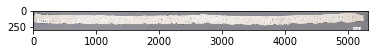

In [55]:
img = np.asarray(Image.open(str(train_max_width[1])))
plt.imshow(img)
plt.show()

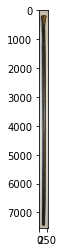

In [56]:
img = np.asarray(Image.open(str(train_max_height[1])))
plt.imshow(img)
plt.show()

In [70]:
img_pil = Image.fromarray(img)
img_pil.size

(300, 7531)

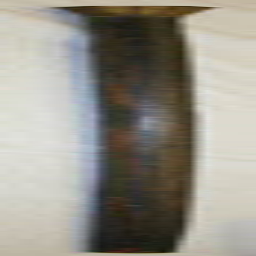

In [76]:
resized_img = cv2.resize(img, (256, 256))
resized_img_pil = Image.fromarray(resized_img)
resized_img_pil

## We cannot resize these images directly because the images will lose many features. 

In [77]:
def resize_weird_images(img, SIZE):
    aspect_ratio = img.size[0] / img.size[1]
    if aspect_ratio < 0.5:
        w_resized = int(img.size[0] * SIZE / img.size[1])
        resized = img.resize((w_resized ,SIZE))
        pad_width = SIZE - w_resized
        padding = (pad_width // 2, 0, pad_width-(pad_width//2), 0)
        img = ImageOps.expand(resized, padding, fill="white")
    elif aspect_ratio > 2:
        h_resized = int(img.size[1] * SIZE / img.size[0])
        resized = img.resize((SIZE, h_resized))
        pad_height = SIZE - h_resized
        padding = (0, pad_height // 2, 0, pad_height-(pad_height//2))
        img = ImageOps.expand(resized, padding, fill="white")
    
    return img

In [79]:
img_pil = resize_weird_images(img_pil, 256)
img_pil.size

(256, 256)

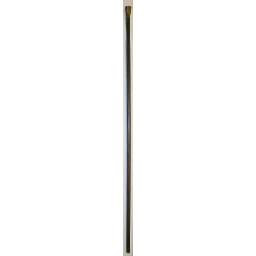

In [80]:
img_pil

## Experiment on removing backgrounds

In [85]:
def rm_bkg(img):
    y_size,x_size,col = img.shape
    
    for y in range(y_size):
        for r in range(1,6):
            col = img[y, x_size-r] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
        for l in range(5):
            col = img[y, l] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]

    for x in range(x_size):
        for d in range(1,6):
            col = img[y_size-d, x] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
        for u in range(5):
            col = img[u, x] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
    
    return img

## Take two images for example

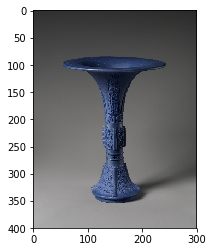

In [89]:
img1 = cv2.imread("../input/train/1008c7837081f985.png")
plt.imshow(img1)

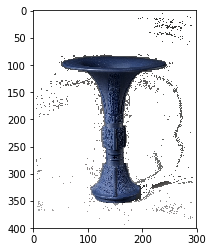

In [90]:
rm_img1 = rm_bkg(img1)
plt.imshow(rm_img1)

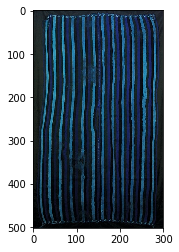

In [97]:
img2 = cv2.imread("../input/train/1006665c0aad488.png")
plt.imshow(img2)

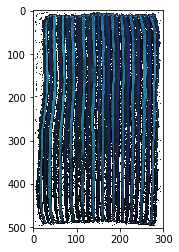

In [98]:
rm_img2 = rm_bkg(img2)
plt.imshow(rm_img2)

## Some images might work, but some will lose features.

## Experiment on extracting contours

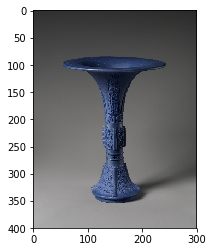

In [99]:
img1 = cv2.imread("../input/train/1008c7837081f985.png")
plt.imshow(img1)

In [101]:
img_pil1 = Image.fromarray(img1)
img1_contour = img_pil1.filter(ImageFilter.CONTOUR)

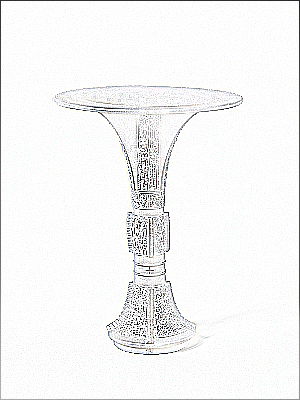

In [102]:
img1_contour

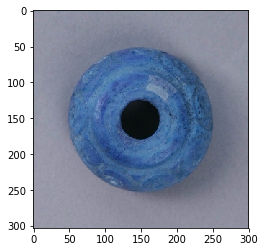

In [109]:
img2 = cv2.imread("../input/train/10b57e6a57480cb2.png")
plt.imshow(img2)

In [110]:
img_pil2 = Image.fromarray(img2)
img2_contour = img_pil2.filter(ImageFilter.CONTOUR)

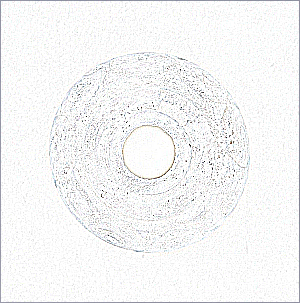

In [111]:
img2_contour